In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import PIL
import pickle
from PIL import *
import cv2
import tensorflow as tf
import keras
from keras.applications import DenseNet121 # 2017 architecture
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, optimizers
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')
facialexpression_df = pd.read_csv('/content/drive/MyDrive/DL Facial Recognition /icml_face_data.csv')

Mounted at /content/drive


In [4]:
facialexpression_df = facialexpression_df.drop(columns = " Usage")


In [5]:
facialexpression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
def string2array(x):
    return np.array(x.split(' ')).reshape(48,48,1).astype('float32')

In [7]:
def resize(x):
    img = x.reshape(48,48)
    temp = cv2.resize(img, dsize=(48,48), interpolation = cv2.INTER_CUBIC)
    return np.stack([temp,temp,temp], axis = 2)

In [8]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x : string2array(x))
facialexpression_df[' pixels'] =  facialexpression_df[' pixels'].apply(lambda x : resize(x))

In [9]:
facialexpression_df.shape

(35887, 2)

In [10]:
label_to_text = {0: 'anger', 1 : 'disgust', 2 : 'fear', 3 : 'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [11]:
facialexpression_df[' pixels'][1].shape

(48, 48, 3)

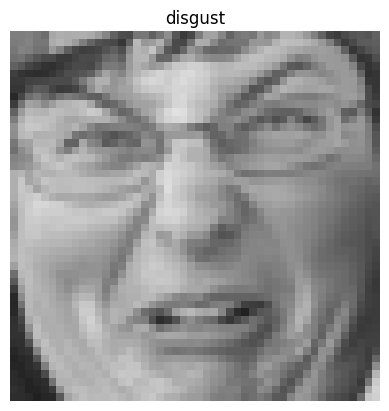

In [12]:
emotions = [1]
for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion']==i][:1]

    img = data[' pixels'].item()
    img = img.reshape(48,48, 3)

    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img/255)
    plt.axis('off')

In [13]:
facialexpression_df.emotion.value_counts().index

Index([3, 6, 4, 2, 0, 5, 1], dtype='int64', name='emotion')

In [14]:
facialexpression_df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [15]:
class1 = facialexpression_df.loc[facialexpression_df['emotion'] == 1]
class1.shape

(547, 2)

In [16]:
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(35887,48,48,3)

print(X.shape, y.shape)

(35887, 48, 48, 3) (35887, 7)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32298, 48, 48, 3), (1795, 48, 48, 3), (32298, 7), (1795, 7))

In [19]:
X_train = X_train/255
X_val   = X_val /255
X_test  = X_test/255

In [20]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [21]:
from keras.applications import MobileNetV2

input_shape = (48,48, 3)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

MNmodel = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(7, activation='sigmoid')
])

MNmodel.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 256)               1310976   
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3570759 (13.62 MB)
Trainable params: 3536647 (13.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [22]:
MNmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [23]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "/content/drive/MyDrive/DL Facial Recognition /MNFacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [24]:
history = MNmodel.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data= (X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
504/504 [==============================] - ETA: 0s - loss: 1.5852 - accuracy: 0.3942
Epoch 1: val_loss improved from inf to 2.92419, saving model to /content/drive/MyDrive/DL Facial Recognition /MNFacialExpression_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 81s 102ms/step - loss: 1.5852 - accuracy: 0.3942 - val_loss: 2.9242 - val_accuracy: 0.1310
Epoch 2/100
504/504 [==============================] - ETA: 0s - loss: 1.3470 - accuracy: 0.4876
Epoch 2: val_loss improved from 2.92419 to 2.81782, saving model to /content/drive/MyDrive/DL Facial Recognition /MNFacialExpression_weights.hdf5
504/504 [==============================] - 46s 91ms/step - loss: 1.3470 - accuracy: 0.4876 - val_loss: 2.8178 - val_accuracy: 0.3166
Epoch 3/100
504/504 [==============================] - ETA: 0s - loss: 1.2836 - accuracy: 0.5086
Epoch 3: val_loss improved from 2.81782 to 1.91113, saving model to /content/drive/MyDrive/DL Facial Recognition /MNFacialExpression_weights.hdf5
504/504 [==============================] - 46s 91ms/step - loss: 1.2836 - accuracy: 0.5086 - val_loss: 1.9111 - val_accuracy: 0.4376
Epoch 4/100
504/504 [==============================] - ETA: 0s - loss: 1.2569 - accuracy: 0.5203
Epoch 4: val_loss

In [25]:
score = MNmodel.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

57/57 [==============================] - 1s 17ms/step - loss: 1.2810 - accuracy: 0.5209
Test Accuracy: 0.5208913683891296


In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

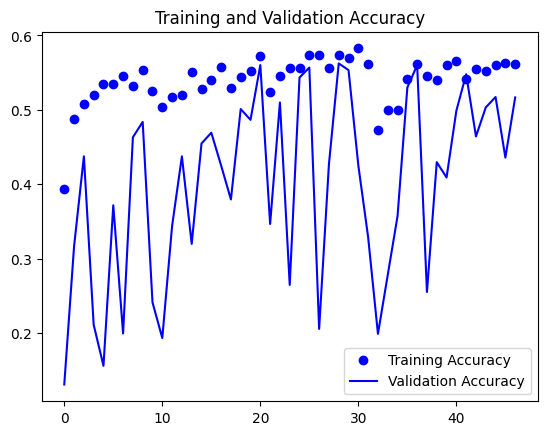

In [28]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

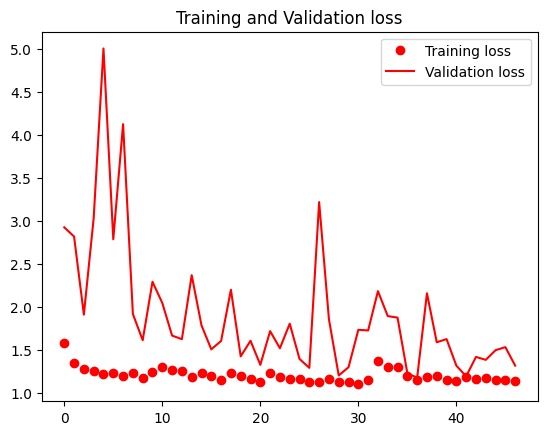

In [29]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [30]:
predicted_classes = np.argmax(MNmodel.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

57/57 [==============================] - 1s 7ms/step


<Axes: >

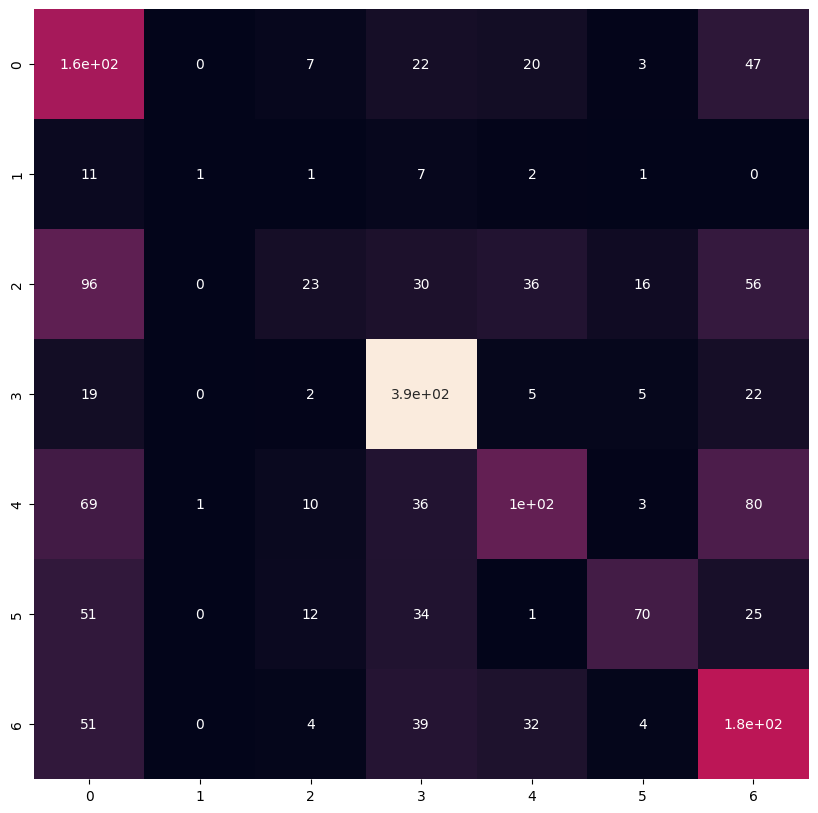

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

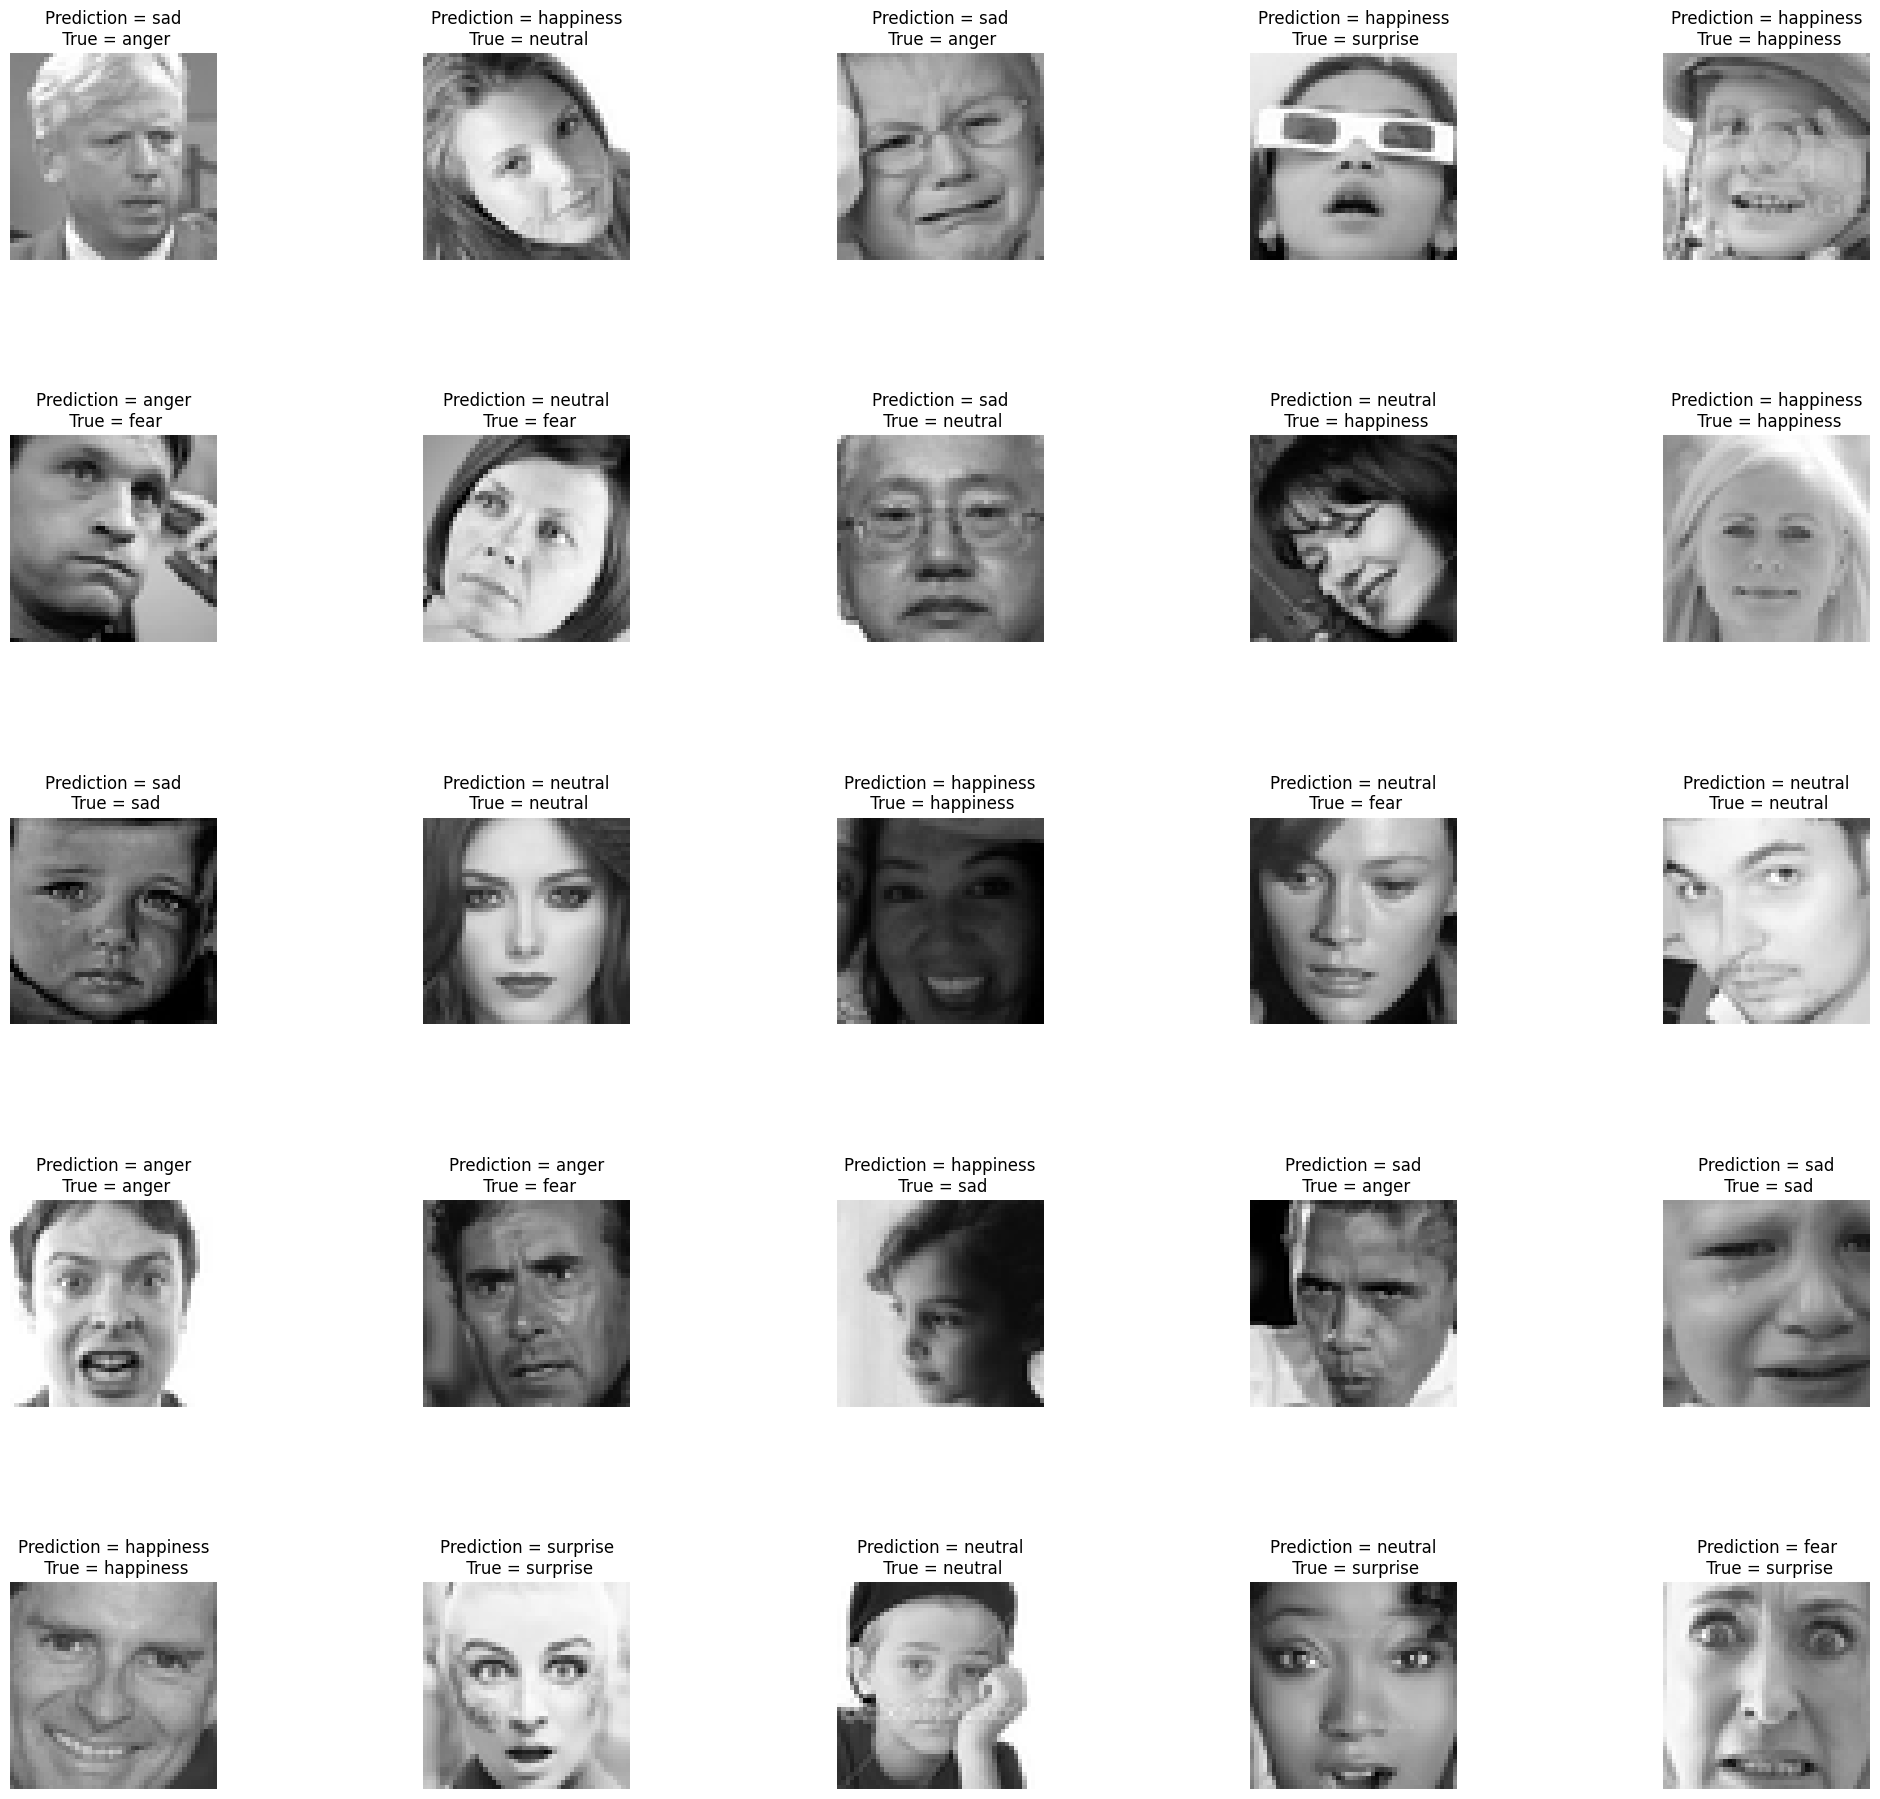

In [32]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i], cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [33]:
# Compute accuracy
accuracy = np.mean(predicted_classes == y_true)

print("Accuracy:", accuracy)

Accuracy: 0.520891364902507
